```
This notebook sets up and runs a set of benchmarks to compare
different numerical discretizations of the SWEs

Copyright (C) 2016, 2017, 2018  SINTEF ICT

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline
#%config InlineBackend.figure_format = 'retina'

#Import packages we need
import numpy as np
from matplotlib import animation, rc
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import os
import pycuda.driver as cuda
from pycuda.compiler import SourceModule
import datetime
import sys

#Set large figure sizes
#rc('figure', figsize=(16.0, 12.0))
#rc('animation', html='html5')
plt.rcParams["animation.html"] = "jshtml"

#Import our simulator
from gpuocean.SWEsimulators import KP07, CDKLM16
from gpuocean.utils import PlotHelper, Common, IPythonMagic

In [2]:
%cuda_context_handler gpu_ctx

In [3]:
#Create output directory for images
imgdir='images_' + datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
os.makedirs(imgdir)
print("Saving images to " + imgdir)

Saving images to images_2023_03_06-10_45_10


In [4]:

def sim_plotter(sim, T, zoom=False):
    
    sim.step(T)
    eta, hu, hv = sim.download(interior_domain_only=True)

    #Create figure and plot initial conditions
    fig = plt.figure(figsize=(12, 8))
    
    x0, x1 =0, None
    y0, y1 =0, None
    domain_extent = [0, sim.nx*sim.dx, 0, sim.ny*sim.dy]
    if zoom:
        midx = sim.nx//2 
        midy = sim.ny//2 
        x0, x1 = midx - 25, midx + 26
        y0, y1 = midy - 25, midy + 26
        domain_extent = [x0*sim.dx, x1*sim.dx, y0*sim.dy, y1*sim.dy]
    
    ax_eta = plt.subplot(1,3,1)
    sp_eta = ax_eta.imshow(eta[y0:y1,x0:x1], interpolation="none", origin='lower', vmin=-0.01, vmax=0.01, extent=domain_extent, cmap="coolwarm")
    
    ax_u = plt.subplot(1,3,2)
    sp_u = ax_u.imshow(hu[y0:y1,x0:x1], interpolation="none", origin='lower', vmin=-0.05, vmax=0.05, extent=domain_extent, cmap="coolwarm")
    
    ax_v = plt.subplot(1,3,3)
    sp_v = ax_v.imshow(hv[y0:y1,x0:x1], interpolation="none", origin='lower', vmin=-0.05, vmax=0.05, extent=domain_extent, cmap="coolwarm")
    
            

In [5]:
def crosssecs(sim):
    eta, hu, hv = sim.download(interior_domain_only=True)

    midx = sim.nx//2 
    midy = sim.ny//2 
    x0, x1 = midx - 25, midx + 26
    y0, y1 = midy - 25, midy + 26


    fig, axs = plt.subplots(1,2, figsize=(12,6))
    axs[0].set_title("hu. Cut along y")
    axs[1].set_title("hv. Cut along x")
    for offset in [10,15,20,25,30]:
        axs[0].plot(hu[y0:y1, midx-offset], label=str(offset)+" cells away from center")
        axs[1].plot(hv[midy-offset, x0:x1], label=str(offset)+" cells away from center")


Shared sim args

In [6]:
# Set initial conditions common to all simulators
sim_args = {
"gpu_ctx": gpu_ctx,
"nx": 200, "ny": 400,
"dx": 100.0, "dy": 100.0,
"g": 9.81,
"f": 0.0012,
"coriolis_beta": 0, #1.0e-6,
"r": 0.0
}

Shared init cond

In [7]:
def addCentralBump(eta0, nx, ny, dx, dy, ghosts, scale_width=1e5, scale_height=1.0):
    midx = nx*dx/2
    midy = ny*dy/2    
    
    for ix in range(nx):
        for iy in range(ny):
            d = np.sqrt( ((ix+0.5)*dx - midx)**2  + ((iy+0.5)*dy - midy)**2 ) 
            eta0[iy+ghosts[0],ix+ghosts[1]] = scale_height * np.exp(-d**2/scale_width)


In [8]:
## INITIAL CONDITIONS
ghosts = np.array([2,2,2,2]) # north, east, south, west
dataShape = (sim_args["ny"] + ghosts[0]+ghosts[2], 
             sim_args["nx"] + ghosts[1]+ghosts[3])

H = np.ones((dataShape[0]+1, dataShape[1]+1), dtype=np.float32) * 60.0
eta0 = np.zeros(dataShape, dtype=np.float32)
hu0 = np.zeros(dataShape, dtype=np.float32)
hv0 = np.zeros(dataShape, dtype=np.float32)

#Create bump in to lower left of domain for testing
addCentralBump(eta0, sim_args["nx"], sim_args["ny"], sim_args["dx"], sim_args["dy"], ghosts)

init_args = {"H": H, "eta0": eta0, "hu0": hu0, "hv0": hv0}


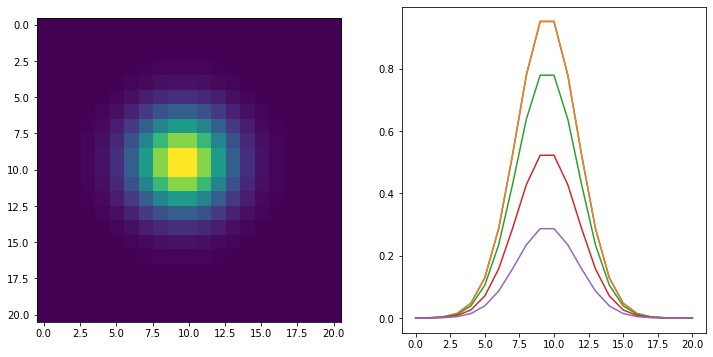

In [9]:
midy = sim_args["ny"]//2 +2 
midx = sim_args["nx"]//2 +2 
fig, axs = plt.subplots(1,2, figsize=(12,6))
axs[0].imshow(eta0[midy-10:midy+11,midx-10:midx+11])
for offset in range(5):
    axs[1].plot(eta0[midy-offset,midx-10:midx+11])

SU-KP without Coriolis

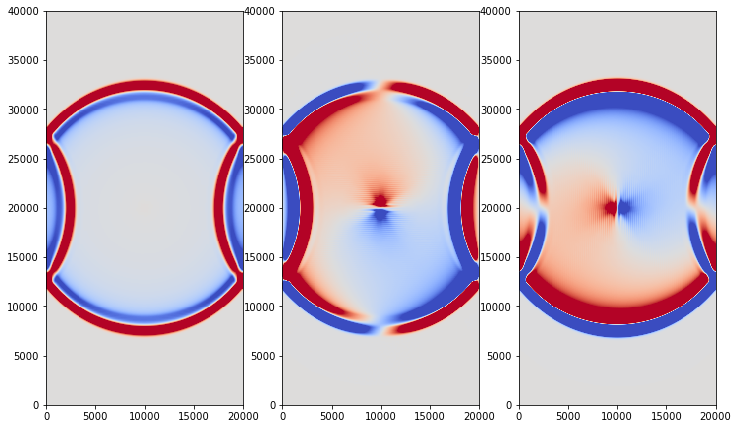

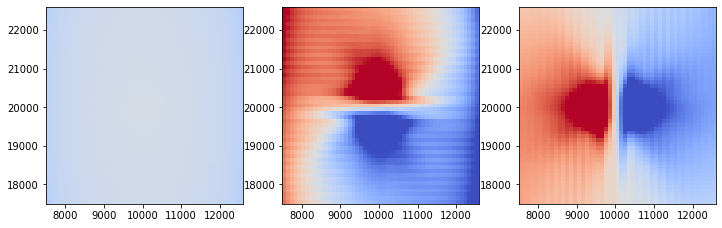

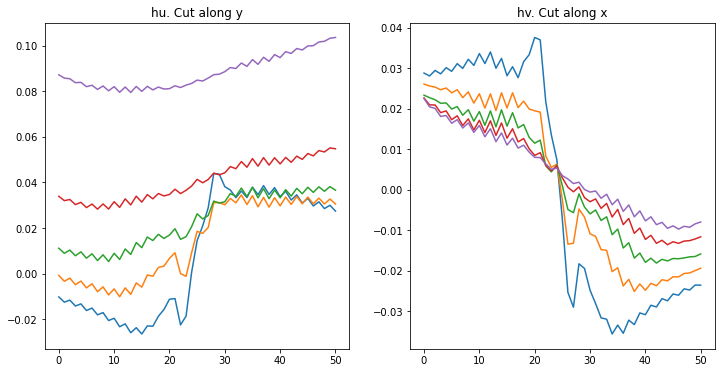

In [10]:
from importlib import reload
reload(KP07)

#Initialize simulator
sim_kp = KP07.KP07(**init_args, **sim_args, dt=1.0, use_rk2=True, flux_delimiter=1.0)

#Run a simulation and plot it
sim_plotter(sim_kp, T=500, zoom=False)
sim_plotter(sim_kp, T=500, zoom=True)
crosssecs(sim_kp)

CDKLM 

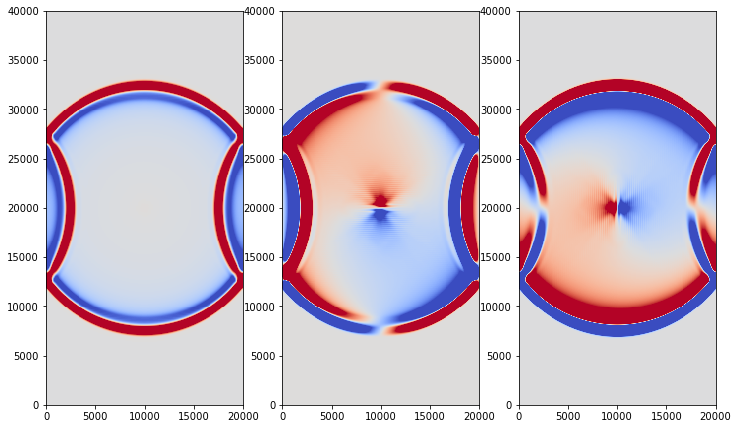

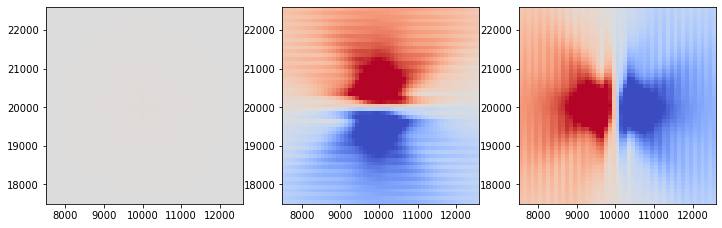

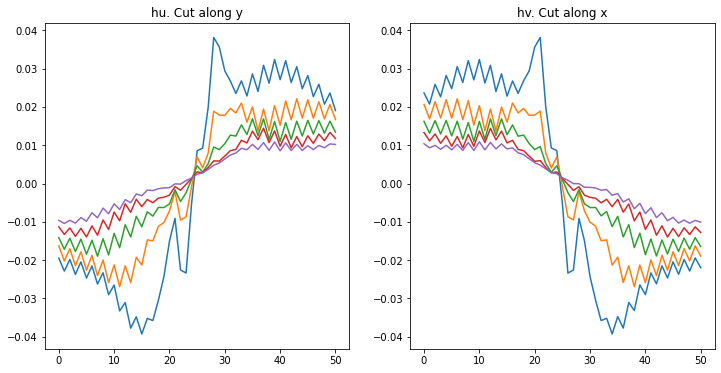

In [16]:
from importlib import reload
reload(CDKLM16)

#Initialize simulator
su_sim = CDKLM16.CDKLM16(**init_args, **sim_args, dt=0.0, rk_order=2, flux_delimiter=1.0, theta=1.5)

#Run a simulation and plot it
sim_plotter(su_sim, T=500, zoom=False)
sim_plotter(su_sim, T=100, zoom=True)
crosssecs(su_sim)

CU-CDKLM

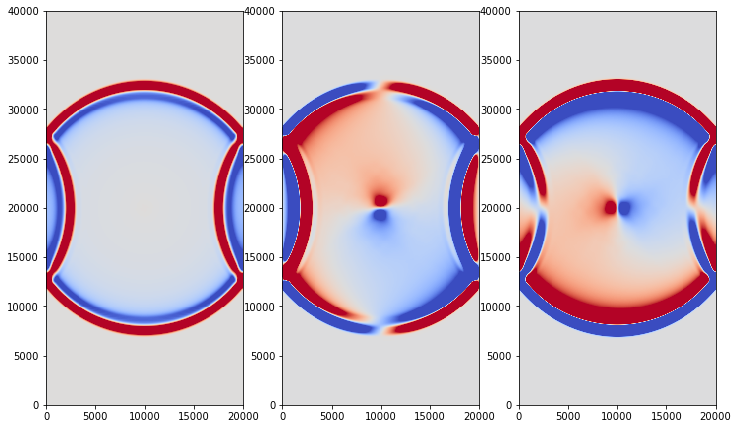

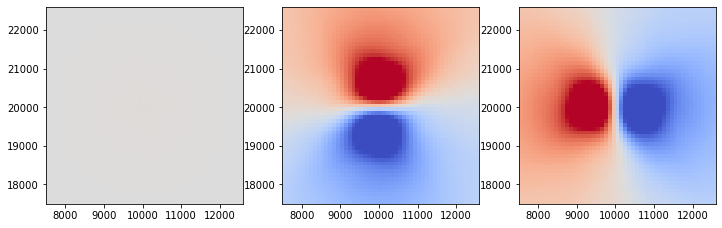

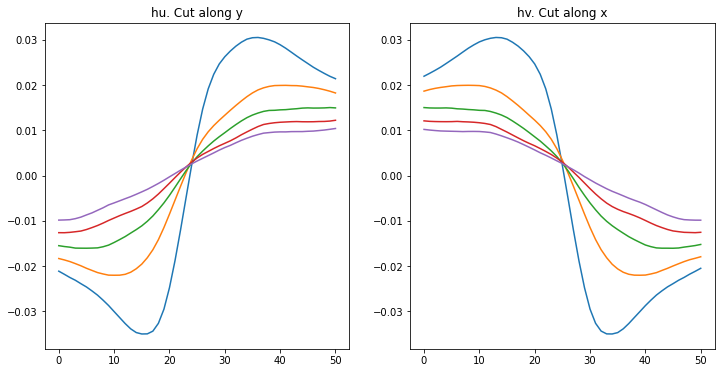

In [15]:
from importlib import reload
reload(CDKLM16)

#Initialize simulator
cu_sim = CDKLM16.CDKLM16(**init_args, **sim_args, dt=0.0, rk_order=2, flux_delimiter=0.0, theta=1.5)

#Run a simulation and plot it
sim_plotter(cu_sim, T=500, zoom=False)
sim_plotter(cu_sim, T=100, zoom=True)
crosssecs(cu_sim)